In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from karateclub.graph_embedding import Graph2Vec

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, learning_curve
from sklearn.metrics import *

In [2]:
CAUSAL_COEFF_STRENGTH = 1.5
SEED = 39

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show()

def plot_embeddings(embeddings, labels):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], c='tab:blue', s=5, alpha=0.5, label='control')
    ax.scatter(embeddings[labels == 1, 0], embeddings[labels == 1, 1], c='tab:orange', s=5, alpha=0.5, label='patological')
    ax.set_title('Graph2Vec embeddings')
    plt.legend()
    plt.show()

# Load EC networks into a netwokx dataset

In [4]:
networks_dir = "../../Datasets/SynapseSnap/ischemic-cortical-subjects/"

# List of all networks
np_files = os.listdir(networks_dir)

# Get labels from file names
labels = np.array([np_file[4:7] == 'PAT' for np_file in np_files])

# Load all networks, and calculate mean score and std
np_matrices = [np.load(os.path.join(networks_dir, np_file))[1] for np_file in np_files]
score_mean, score_std = np.array(np_matrices).mean(), np.array(np_matrices).std()

# Binarize networks
np_networks = np_matrices > score_mean + CAUSAL_COEFF_STRENGTH * score_std

# Convert to networkx graphs
dataset = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks]

# Balance of control and patological samples
n_control = len(labels) - labels.sum()
n_patological = labels.sum()
print(f"No of control samples: {n_control}")
print(f"No of patological samples: {n_patological}")

No of control samples: 28
No of patological samples: 29


## Plot a few samples

In [5]:
np.random.seed(44)
indices = np.random.choice(len(dataset), size=8, replace=False)

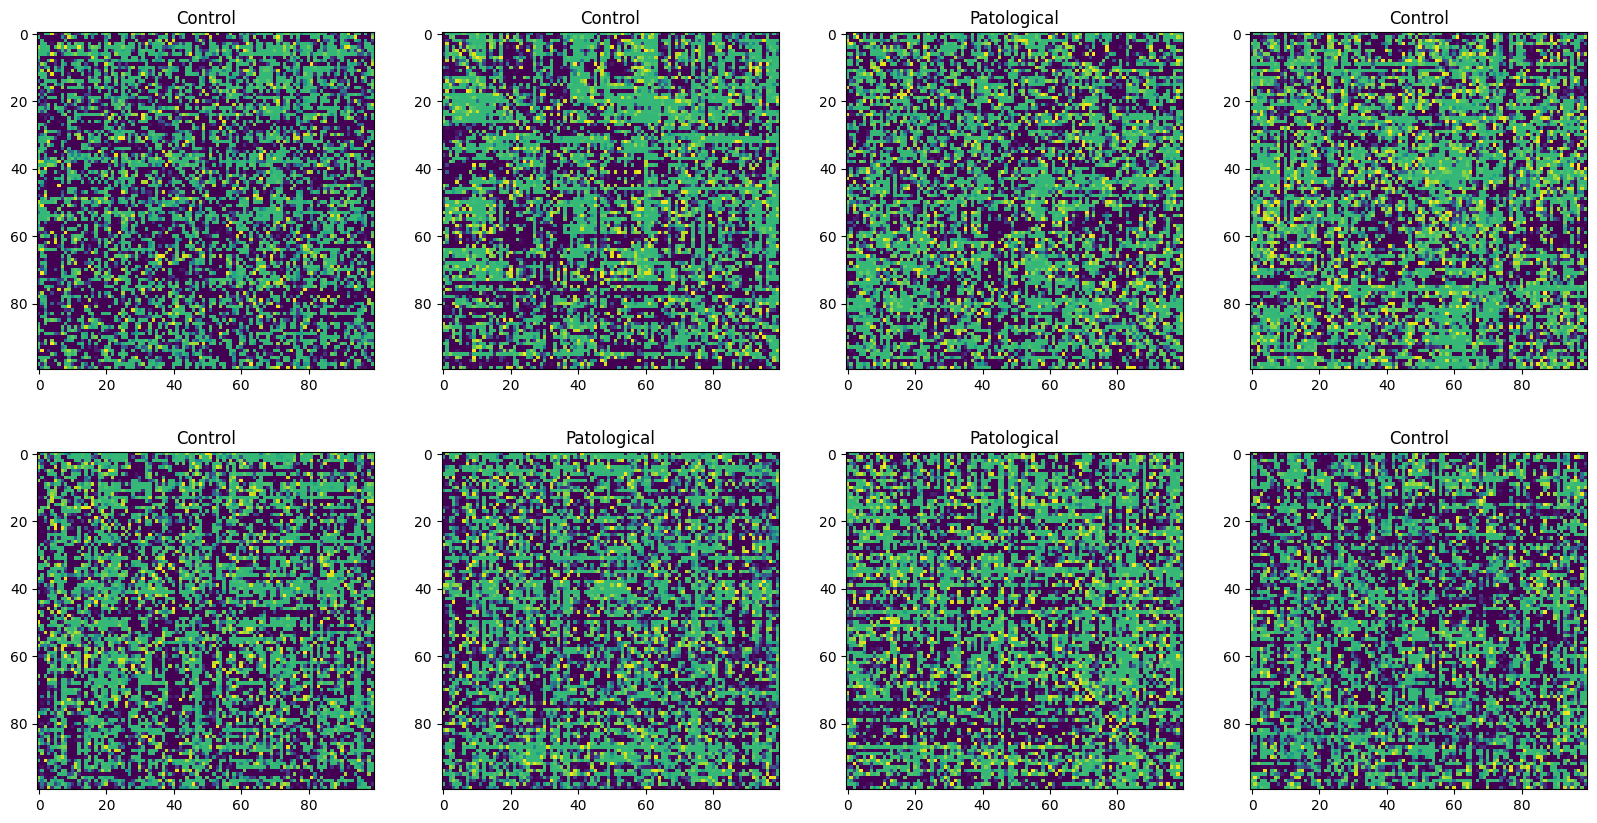

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in zip(indices, axes.flatten()):
    net = np_matrices[i]
    ax.imshow(net, cmap='viridis')
    ax.set_title("Patological" if labels[i] else "Control")

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in zip(indices, axes.flatten()):
    net = dataset[i]
    nx.draw(net, ax=ax, pos=nx.circular_layout(net), node_size=5, width=0.1, with_labels=False)
    ax.set_title("Patological" if labels[i] else "Control")

# Embedd using graph2vec

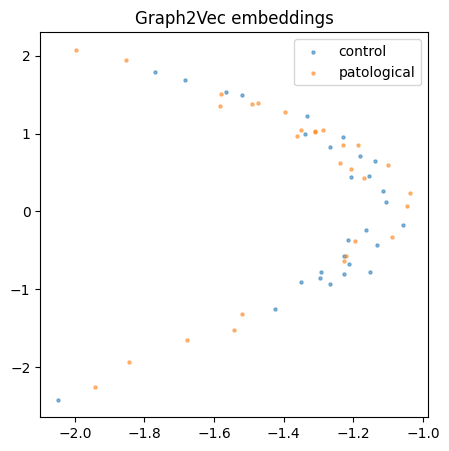

In [26]:
model_2D = Graph2Vec(dimensions=2, wl_iterations=2, epochs=200, seed=SEED, workers=1)
model_2D.fit(dataset)
plot_embeddings(model_2D.get_embedding(), labels)

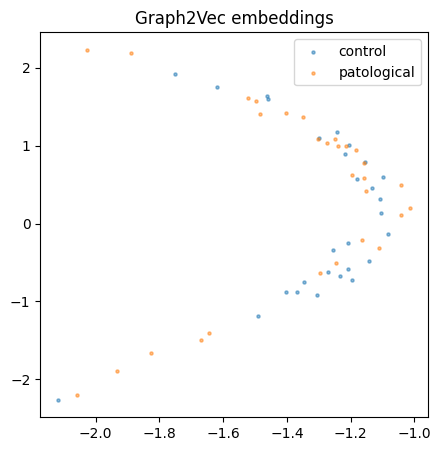

In [7]:
model_2D = Graph2Vec(dimensions=2, wl_iterations=2, epochs=200, seed=SEED)
model_2D.fit(dataset)
plot_embeddings(model_2D.get_embedding(), labels)

# Class separation

In [7]:
HIDDEN_DIM = 16

model = Graph2Vec(dimensions=HIDDEN_DIM, wl_iterations=2, epochs=200)
model.fit(dataset)
embeddings = model.get_embedding()

## The dataset

In [ ]:
# half_test = 20

# # Holdout the test set, keep both classes balanced by taking N of each
# embeddings_con, embeddings_pat = embeddings[labels == 0], embeddings[labels == 1]
# X_test = np.concatenate((embeddings_con[-half_test:], embeddings_pat[-half_test:]))
# y_test = np.concatenate((np.zeros(half_test), np.ones(half_test)))

# permutation = np.random.permutation(2 * half_test)
# X_test, y_test = X_test[permutation], y_test[permutation]

# # The rest is the training set, keep both classes balanced by resampling
# half_train = max(len(embeddings_con) - half_test, len(embeddings_pat) - half_test)
# # X_train = np.concatenate((
# #     embeddings_con[np.random.choice(embeddings_con[:-half_test].shape[0], size=half_train, replace=True)],
# #     embeddings_pat[np.random.choice(embeddings_pat[:-half_test].shape[0], size=half_train, replace=True)]
# # ))
# # y_train = np.concatenate((np.zeros(half_train), np.ones(half_train)))
# X_train = np.concatenate((embeddings_con[:-half_test], embeddings_pat[:-half_test]))
# y_train = np.concatenate((np.zeros(embeddings_con[:-half_test].shape[0]), np.ones(embeddings_pat[:-half_test].shape[0])))

# permutation = np.random.permutation(X_train.shape[0])
# X_train, y_train = X_train[permutation], y_train[permutation]

# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# print(f"Ratio of positive samples in train: {y_train.mean()}")
# print(f"Ratio of positive samples in test: {y_test.mean()}")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Ratio of positive samples in train: {y_train.mean()}")
print(f"Ratio of positive samples in test: {y_test.mean()}")

X_train shape: (39, 16), y_train shape: (39,)
X_test shape: (18, 16), y_test shape: (18,)
Ratio of positive samples in train: 0.5128205128205128
Ratio of positive samples in test: 0.5


# Ridge regression

## Best parameters
- Graph2Vec(dimensions=16, wl_iterations=2, epochs=200)
- test_size: 0.3
- random_state: 42
- alpha: 100.0

## Results
- Train accuracy: 0.62, Test accuracy: 0.61
- Train recall: 0.85, Test recall: 0.89
- Train precision: 0.59, Test precision: 0.57
- Train f1: 0.69, Test f1: 0.70
- Confusion matrix: $$\begin{bmatrix}  3 & 6 \\  1 & 8 \end{bmatrix}$$

### Grid Search with cross validation
It does not seem to work. Always selecting lowest regularization, when scoring accuracy.

In [ ]:
params = {'alpha': np.logspace(-1, 3, 17)}

clf = GridSearchCV(RidgeClassifier(), params, cv=5, scoring='f1', n_jobs=-1)
clf.fit(X_train, y_train)

print(f"Best params: {clf.best_params_}")
print(f"Best score: {clf.best_score_}")

In [ ]:
# Fit Ridge classifier
rc = RidgeClassifier(alpha=100.)
rc.fit(X_train, y_train)
y_train_hat, y_test_hat = rc.predict(X_train), rc.predict(X_test)

# Calculate accuracy
train_accuracy = (y_train_hat == y_train).mean()
test_accuracy = (y_test_hat == y_test).mean()
print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")
print(f"Train recall: {recall_score(y_train, y_train_hat):.2f}, Test recall: {recall_score(y_test, y_test_hat):.2f}")
print(f"Train precision: {precision_score(y_train, y_train_hat):.2f}, Test precision: {precision_score(y_test, y_test_hat):.2f}")
print(f"Train f1: {f1_score(y_train, y_train_hat):.2f}, Test f1: {f1_score(y_test, y_test_hat):.2f}")
plot_confusion_matrix(y_test, y_test_hat)

# Random Forest

In [ ]:
# Fit Ridge classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_leaf=8, random_state=42, oob_score=False)
rf.fit(X_train, y_train)
y_train_hat, y_test_hat = rf.predict(X_train), rf.predict(X_test)

# Calculate accuracy
train_accuracy = (y_train_hat == y_train).mean()
test_accuracy = (y_test_hat == y_test).mean()
print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")
print(f"Train recall: {recall_score(y_train, y_train_hat):.2f}, Test recall: {recall_score(y_test, y_test_hat):.2f}")
print(f"Train precision: {precision_score(y_train, y_train_hat):.2f}, Test precision: {precision_score(y_test, y_test_hat):.2f}")
print(f"Train f1: {f1_score(y_train, y_train_hat):.2f}, Test f1: {f1_score(y_test, y_test_hat):.2f}")
plot_confusion_matrix(y_test, y_test_hat)

# MLP

In [ ]:
import torch
from torch import nn

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

In [ ]:
model = nn.Sequential(
    nn.Linear(HIDDEN_DIM, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)
model.to(device)

loss_fn = nn.BCEWithLogitsLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred))
    return acc

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 20

loss_train = []
loss_test = []
metric = []
# Create training and testing loop
for epoch in tqdm(range(epochs)):
    ### Training
    # Add a loop to loop through training batches
    
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_logits, y_train)
    loss_train.append(loss.item())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # test_accuracy.append(accuracy_fn(y_test, test_pred))
        metric.append(test_pred[0].item())

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        loss_test.append(test_loss.item())

In [ ]:
# Plot loss curves
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(metric)